In [1]:
# Author: George Russell Murray
# Date: 12/27/2018

In [2]:
# Library Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Camera Calibration

In [7]:
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, camera_matrix, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    return ret, camera_matrix, distortion_coefficients, rvecs, tvecs
    
    #         # Draw and display the corners
    #         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #         plt.imshow(img)


In [8]:
# Calling the calibrate_camera function to generate our camera matrix and distortion coefficients
ret, camera_matrix, distortion_coefficients, rvecs, tvecs = calibrate_camera()

# Implementing Distortion Correction

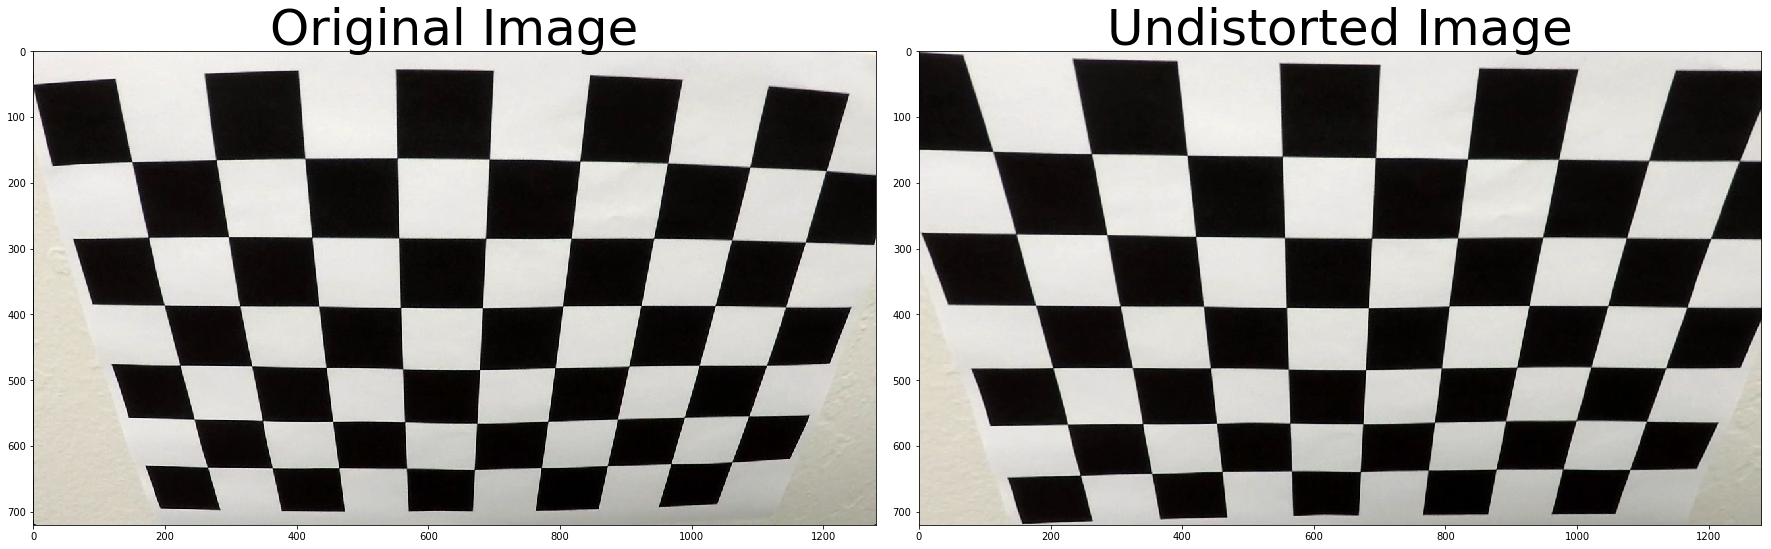

In [9]:
# Reading in Distortion Correction Image
img = mpimg.imread('camera_cal/calibration2.jpg')
# cv2 undistort call 
undistorted_img = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
# Outputting image using matplotlib
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [23]:
# Getting Image to Threshold
video_stream = cv2.VideoCapture("project_video.mp4")
_, test_frame = video_stream.read()


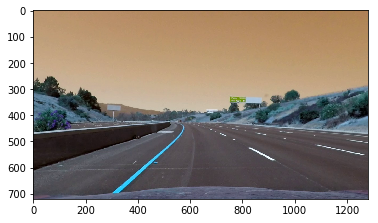

In [22]:
# Undistorting Test Image
test_undistorted_image = cv2.undistort(test_frame, camera_matrix, distortion_coefficients, None, camera_matrix)
# Clean up noise

plt.imshow(test_undistorted_image)

# Implementing Color & Gradient Thresholds

In [26]:
def color_gradient_threshold(undistorted_img):
    hls_undistorted = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
    s_channel = hls_undistorted[:, :, 2]
    l_channel = hls_undistorted[:, :, 1]
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    # Clean up noise in image by applying a Gaussian Blur
    blurred_gray = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(gray, cv2.cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold the gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (s_channel <= thresh_max)] = 1

    # Threshold the color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    return combined_binary



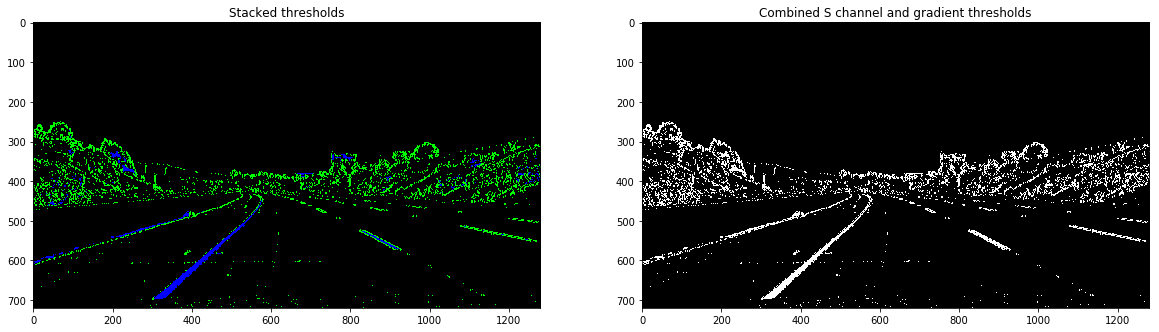

In [28]:
thresholded_img = color_gradient_threshold(test_undistorted_image)

# Apply Perspective Transform

In [38]:
def apply_perspective(frame):
    
    frame_size = (frame.shape[1], frame.shape[0])
    w = frame.shape[1]
    h = frame.shape[0]
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    M = cv2.getPerspectiveTransform(src, dst)
    warped_frame = cv2.warpPerspective(frame, M, frame_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped_frame, cmap='gray')
    return warped_frame

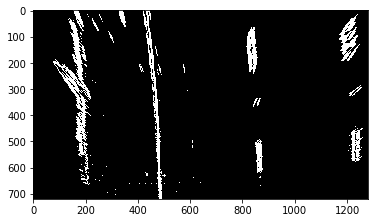

In [40]:
warped_frame = apply_perspective(thresholded_img)